In [2]:
import splat
import wisps
import matplotlib.pyplot as plt
from wisps.data_analysis import selection_criteria as sel_crt
from wisps.simulations import selection_function as slf
import numpy as np
import pandas as pd

import numba
import matplotlib as mpl
mpl.rcParams['font.size'] = 18

#read in the data 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive #to import my own module, I must first follow this procedure:
from itertools import combinations
%tensorflow_version 2.x
import kerastuner as kt
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow.keras.metrics as k_metrics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import tensorflow.keras.metrics as k_metrics
from keras import optimizers
import IPython

drive.mount('/content/gdrive/')

#%%capture  output
import splat
import itertools
from tqdm import tqdm
from numba import cuda

In [3]:
sf=pd.read_pickle(wisps.OUTPUT_FILES+'/selection_function.pkl') #the simulated spectral data

In [4]:
#selection objects 
rfdict=pd.read_pickle(wisps.OUTPUT_FILES+'/random_forest_classifier.pkl') #the classifier 
indices_to_use= pd.read_pickle(wisps.OUTPUT_FILES+'/best_indices_to_use.pkl')

neural_network= pd.read_hdf('/users/caganze/desktop/model_loss_weighted_with_galax_sptft.h5')

ValueError: No dataset in HDF5 file.

In [4]:
simulated_data=pd.DataFrame.from_records(pd.DataFrame(sf).values.flatten()).sample(n=10000)

In [5]:
sampled_data=simulated_data

In [6]:
from scipy import stats
def f_test_comp(x):
    return stats.f.cdf(x, 2, 1, 0, scale=1)
sampled_data['f_test_cdf']=(sampled_data.spex_chi/sampled_data.line_chi).apply(f_test_comp)

In [7]:
#things that missed their classification 
sampled_data['missed_label']=sampled_data['sp_old'].apply(wisps.make_spt_number) != sampled_data['spt_new'].apply(wisps.make_spt_number)
sampled_data['missed_label']=1-sampled_data.missed_label.apply(int).apply(float)

In [8]:
import seaborn as sns

In [9]:
cmap=sns.diverging_palette(150, 275, s=80, l=55, n=9, as_cmap=True)

In [10]:
sampled_data['missed_label_outside']= (sampled_data['sp_old'].apply(wisps.make_spt_number).between(17, 41)).apply(int)

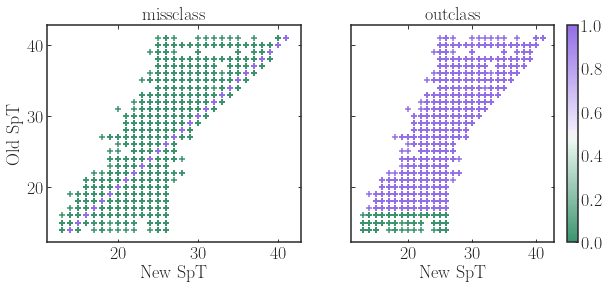

In [11]:
fig, ax=plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10, 4))

c=ax[0].scatter(sampled_data['spt_new'].apply(wisps.make_spt_number),sampled_data['sp_old'].apply(wisps.make_spt_number), c= sampled_data['missed_label'].values,
            marker='+', cmap=cmap)

ax[1].scatter(sampled_data['spt_new'].apply(wisps.make_spt_number),sampled_data['sp_old'].apply(wisps.make_spt_number), c= sampled_data['missed_label_outside'].values,
            marker='+', cmap=cmap)

ax[0].set_ylabel('Old SpT', fontsize=18)
ax[1].set_xlabel('New SpT', fontsize=18)
ax[0].set_xlabel('New SpT', fontsize=18)

ax[0].set_title('missclass', fontsize=18)
ax[1].set_title('outclass', fontsize=18)
plt.colorbar(c)

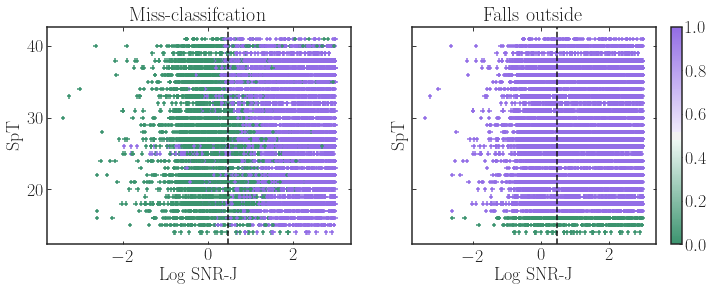

In [12]:
fig, ax=plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12, 4))
c=ax[0].scatter(sampled_data.snr1.apply(np.log10), 
            sampled_data.sp_old.apply(wisps.make_spt_number), marker='+',
            s=20, c=sampled_data['missed_label'].values, cmap=cmap, alpha=1.)

ax[1].scatter(sampled_data.snr1.apply(np.log10), 
            sampled_data.sp_old.apply(wisps.make_spt_number), marker='+',
            s=20, c=sampled_data['missed_label_outside'].values, cmap=cmap, alpha=1.)

ax[0].set_xlabel('Log SNR-J', fontsize=18)
ax[0].set_ylabel('SpT', fontsize=18.)

ax[1].set_xlabel('Log SNR-J', fontsize=18)
ax[1].set_ylabel('SpT', fontsize=18.)

ax[0].axvline(np.log10(3), linestyle='--', color='#111111')
ax[1].axvline(np.log10(3), linestyle='--', color='#111111')
ax[0].set_title('Miss-classifcation', fontsize=20)
ax[1].set_title('Falls outside', fontsize=20)
plt.colorbar(c)
#plt.savefig(wisps.OUTPUT_FIGURES+'/missclassfiction_select.pdf')

In [13]:
sampled_data.shape

(10000, 28)

In [14]:
sampled_data.shape

(10000, 28)

In [15]:
sampled_data['Names']=['spctr'+ str(idx) for idx in sampled_data.index]

In [16]:
sampled_data['spt']=sampled_data['sp_old'].apply(wisps.make_spt_number)

In [17]:
#selection criteria
slc_crts=sel_crt.crts_from_file()

In [18]:
sampled_data.columns

Index(['snr1', 'snr2', 'snr3', 'snr4', 'H_2O-1/J-Cont', 'H_2O-2/H_2O-1',
       'H-cont/H_2O-1', 'CH_4/H_2O-1', 'H_2O-2/J-Cont', 'H-cont/J-Cont',
       'CH_4/J-Cont', 'H-cont/H_2O-2', 'CH_4/H_2O-2', 'CH_4/H-Cont',
       'H_2O-1+H_2O-2/J-Cont', 'H_2O-1+H_2O-2/H-Cont', 'H_2O-1+CH_4/J-Cont',
       'H_2O-2+CH_4/J-Cont', 'H_2O-1+CH_4/H-Cont', 'H_2O-2+CH_4/H-Cont',
       'f_test', 'line_chi', 'spex_chi', 'spt_new', 'sp_old', 'f_test_cdf',
       'missed_label', 'missed_label_outside', 'Names', 'spt'],
      dtype='object')

In [19]:
cands=pd.read_pickle(wisps.OUTPUT_FILES+'/true_spectra_cands.pkl')

In [ ]:
#plot candidates by their selection method
#how which objects where selected by which method
#in snr s[ectral tyep space

In [20]:
obsfs=cands.spectra.apply(lambda x: x.f_test)
obsnsr=cands.spectra.apply(lambda x: x.snr['snr1'])

(0.0, 0.5)

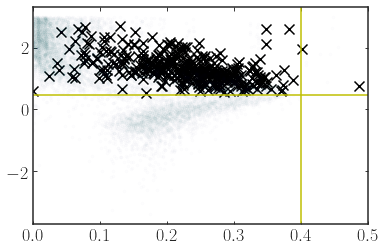

In [21]:
plt.plot(sampled_data.f_test_cdf, sampled_data.snr1.apply(np.log10), '.', alpha=0.008)
plt.scatter(obsfs, np.log10(obsnsr), s=100, marker='x', c='k')
plt.axhline(np.log10(3), c='y')
plt.axvline(.4, c='y')
plt.xlim([0., 0.5])

#### Define a bunch of selection processes

In [22]:
#define a number of selectors 
#each selection should a column of zeros and ones corresponding
#to where objects were selected
#each selector input is the simulated df

def select_by_indices(df):
    #use spectral indices
    good_indices=[slc_crts[k] for k in indices_to_use.keys()]
    cands=[]
    #indices work in log-scale now
    
    for idx, k in zip(good_indices, indices_to_use.keys()):
        spt_range=indices_to_use[k]
        bs=idx.shapes
        bx=[x for x in bs if x.shape_name==spt_range][0]
        df_to_use=wisps.Annotator.reformat_table(df[[idx.xkey, idx.ykey]]).reset_index(drop=True)
        
        sel, bools= bx._select(np.array([df_to_use.values[:,0], df_to_use.values[:, 1]]))
    
        classifics=df.spt_new.apply(lambda x: wisps.is_in_that_classification(x, spt_range) ).values
        
        df['selected_by_{}'.format(spt_range)]=False
        df['selected_by_{}'.format(spt_range)]=(classifics & bools)
        
        

def select_by_f_test(df):
    df['f_test_label']=False
    bools=(df.f_test_cdf <.4).values
    df.loc[bools, 'f_test_label']=True
    
def remove_infinities_and_nans(array):
    infinbools=np.logical_or(array < -1e10, array > 1e10)
    nanbools=np.isnan(array)
    mask=np.logical_or(infinbools, nanbools)
    array[mask]=-9999.9
    return array

def apply_scale_rf(x):
    ##scale random forest features
    #replace nans
    y=np.log10(x)
    if np.isnan(y) or np.isinf(y):
        y=np.random.uniform(-99, -98)
    return y

@numba.jit
def select_by_random_forest(df):
    #use the classification given by my rf classifier
    
    rf=rfdict['classifier']
    min_max_scaler=rfdict['sclr']
    features=rfdict['feats']
    
    #apply logs to problematic features the same way I did on my classification
    df[features]=df[features].applymap(apply_scale)
    #scale the features 
    x=df[features].values
    
    pred_set=min_max_scaler.transform(x)
    rf_labels=rf.predict(pred_set)
    
    #return the predictions
    labels=rf_labels
    labels[labels>0.]=1.
    return labels

@numba.jit
def select_by_neuralnet(df):
    features=['H_2O-1/J-Cont', 'H_2O-2/H_2O-1', 'H-cont/H_2O-1', 'CH_4/H_2O-1',
       'H_2O-2/J-Cont', 'H-cont/J-Cont', 'CH_4/J-Cont', 'H-cont/H_2O-2',
       'CH_4/H_2O-2', 'CH_4/H-Cont', 'H_2O-1+H_2O-2/J-Cont',
      'H_2O-1+H_2O-2/H-Cont', 'H_2O-1+CH_4/J-Cont', 'H_2O-2+CH_4/J-Cont',
      'H_2O-1+CH_4/H-Cont', 'H_2O-2+CH_4/H-Cont', 'spt', 'f_test']
    
    return 


#### Add missing features to the data

In [23]:
sampled_data=sampled_data.rename(columns={"f":"f_test"})

In [24]:
sampled_data['x']=sampled_data.spex_chi/sampled_data.line_chi

In [25]:
df=sampled_data

In [26]:
sampled_data.shape

(10000, 31)

In [27]:
select_by_f_test(df)
df.f_test_label=(df['f_test_label']).apply(int)

In [28]:
df['rf_label']=(select_by_random_forest(wisps.Annotator.reformat_table(df)))#*df.missed_label.values

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.5s finished


In [29]:
select_by_indices(df)

In [30]:
df['index_label']=np.logical_or.reduce([df['selected_by_{}'.format(x)].values for x in  indices_to_use.values()])
df.index_label=(df['index_label']).apply(int)

In [31]:
df['idx_ft_label']=np.logical_and(df['index_label'].apply(bool), df['f_test_label'].apply(bool) ).apply(int)

In [32]:
#df['idx_ml_label']=np.logical_and(df['index_label'].apply(bool), df['rf_label'].apply(bool) ).apply(int)

In [33]:
import seaborn as sns 
cmap=sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [34]:
#cmap=sns.diverging_palette(150, 275, s=80, l=55, n=9, as_cmap=True)

In [35]:
df['logsnr']=df['snr2'].apply(np.log10)

In [36]:
from matplotlib.ticker import MultipleLocator

In [37]:
REF_SELECTION_DATA_SET=df

In [38]:
def probability_of_selection(vals, method='f_test_label'):
    """
    probablity of selection for a given snr and spt
    """
    ref_df=REF_SELECTION_DATA_SET
    spt, snr=vals
    #self.data['spt']=self.data.spt.apply(splat.typeToNum)
    floor=np.floor(spt)
    floor2=np.log10(np.floor(snr))
    return np.nanmean(ref_df[method][(ref_df.spt==floor) &(ref_df.snr1.apply(np.log10).between(floor2, floor2+.3))])
@np.vectorize
def selection_function(spt, snr):
    return  probability_of_selection((spt, snr))

In [39]:
df2=pd.DataFrame()
snrs=df.snr1.values
spts=df.spt.values
df2['snr']=snrs
df2['spt']=spts
df2['f_test_label']=selection_function(spts, snrs)
df2['rf_label']=df2[['spt', 'snr']].apply(probability_of_selection, axis=1, method='rf_label')
df2['index_label']=df2[['spt', 'snr']].apply(probability_of_selection, axis=1, method='index_label')

In [40]:
df2['idx_ft_label']=df2[['spt', 'snr']].apply(probability_of_selection, axis=1, method='idx_ft_label')

In [41]:
df2['logsnr']=df2.snr.apply(np.log10)

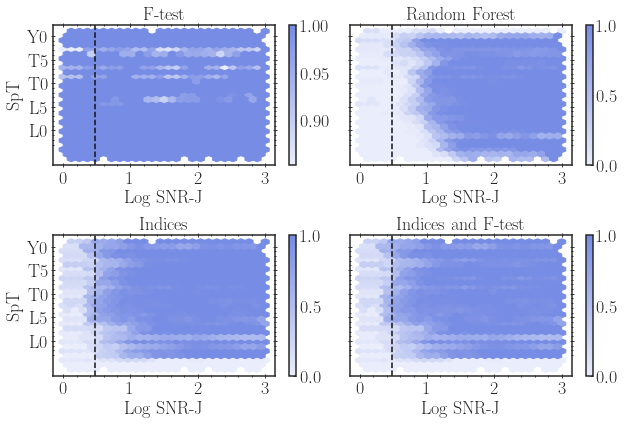

In [42]:
fig, ax=plt.subplots(ncols=2, nrows=2, figsize=(6*1.5, 4*1.5), sharex=False, sharey=True)
df2.plot.hexbin(x='logsnr', y='spt', C='f_test_label', reduce_C_function=np.nanmedian, gridsize=25, cmap=cmap, ax=ax[0][0])
df2.plot.hexbin(x='logsnr', y='spt', C='rf_label', reduce_C_function=np.nanmedian, gridsize=25, cmap=cmap, ax=ax[0][1])
df2.plot.hexbin(x='logsnr', y='spt', C='index_label', reduce_C_function=np.nanmedian, gridsize=25, cmap=cmap, ax=ax[1][0])
df2.plot.hexbin(x='logsnr', y='spt', C='idx_ft_label', reduce_C_function=np.nanmedian, gridsize=25, cmap=cmap, ax=ax[1][1])

#ax[0][0].scatter( sf.data.snr1.apply(np.log10), sf.data.spt, marker='+', color='#111111', alpha=.05)


ax[0][0].set_title('F-test', fontsize=18)
ax[0][1].set_title('Random Forest', fontsize=18)
ax[1][0].set_title('Indices', fontsize=18)
ax[1][1].set_title('Indices and F-test', fontsize=18)

for a in np.concatenate(ax):
    a.set_xlabel('Log SNR-J', fontsize=18)
    a.set_ylabel('SpT', fontsize=18)
    a.axvline(np.log10(3), linestyle='--', color='#111111')
    

    a.tick_params(which='major',direction='inout')
    a.tick_params(which='minor',direction='inout')
    
    a.minorticks_on()
    a.set_yticks(np.arange(17, 41),  minor=True)
    a.set_yticks([20, 25, 30, 35, 40], minor=False)
    a.set_yticklabels(['L0', 'L5', 'T0', 'T5', 'Y0'], minor=False)
    #a.set_xlim([0., 2.3])
    #a.set_ylim([17., 41.])
    
plt.tight_layout()

#fig.axes[3].set_title(r'$\mathcal{S}$')
#fig.axes[2].set_title(r'$\mathcal{S}$')

plt.savefig(wisps.OUTPUT_FIGURES+'/selection_function_samples.pdf', bbox_inches='tight', dpi=200)

In [43]:
df2.to_pickle(wisps.OUTPUT_FILES+'/selection_function_lookup_table.pkl')

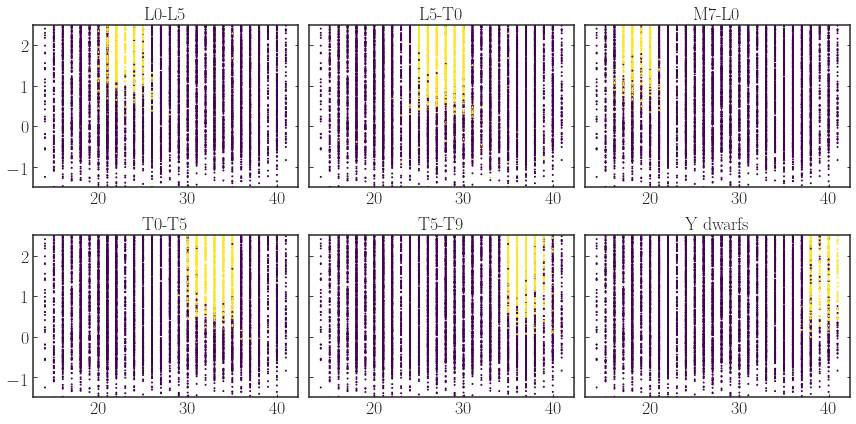

In [44]:
fig, ax=plt.subplots(ncols=3, nrows=2, figsize=(8*1.5, 4*1.5), sharex=False, sharey=True)

for a, grp in zip(np.concatenate(ax), indices_to_use.values() ):
    c=a.scatter(df.spt, df.logsnr, c=df['selected_by_{}'.format(grp)], s=1., cmap='viridis')
    
    a.set_title(grp, fontsize=18)

    #a.set_xlabel('Log SNR-J', fontsize=18)
    #a.set_ylabel('SpT', fontsize=18)
    a.set_ylim([-1.5, 2.5])

#plt.colorbar(c)
    
plt.tight_layout()

In [45]:
spex=wisps.datasets['spex']
spex=wisps.Annotator.reformat_table(spex)

In [46]:
inv_indices_to_use={v: k for k, v in indices_to_use.items()}

In [47]:
inv_indices_to_use

{'L0-L5': 'H_2O-1/J-Cont H_2O-2/H_2O-1',
 'L5-T0': 'H_2O-1+H_2O-2/J-Cont H_2O-1+H_2O-2/H-Cont',
 'M7-L0': 'H_2O-1/J-Cont H_2O-2/J-Cont',
 'T0-T5': 'H_2O-1+H_2O-2/J-Cont H_2O-2+CH_4/J-Cont',
 'T5-T9': 'H_2O-2/J-Cont H_2O-1+CH_4/H-Cont',
 'Y dwarfs': 'H-cont/H_2O-2 H_2O-1+CH_4/H-Cont',
 'subdwarfs': 'H_2O-1/J-Cont H-cont/J-Cont'}

In [48]:
df=wisps.Annotator.reformat_table(df)

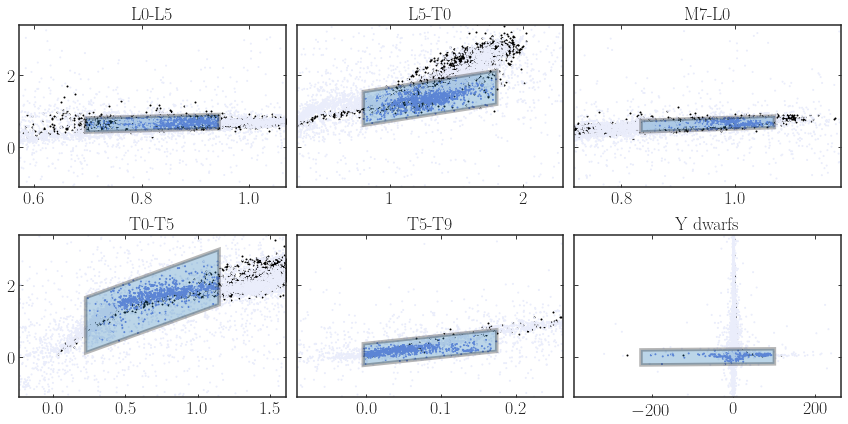

In [49]:
fig, ax=plt.subplots(ncols=3, nrows=2, figsize=(8*1.5, 4*1.5), sharex=False, sharey=True)

for a, grp in zip(np.concatenate(ax), indices_to_use.values() ):
    
    bx=None
    bs=None

    idx_label=inv_indices_to_use[grp]
    
    idx=slc_crts[idx_label]
    
    bs=idx.shapes
    bx=[x for x in bs if x.shape_name==grp][0]
    
   
    c=a.scatter(spex[idx.xkey], spex[idx.ykey], s=1., c='k')
    c=a.scatter(df[idx.xkey], df[idx.ykey], c=df['selected_by_{}'.format(grp)], s=1., cmap=cmap)
    
    bx.plot(ax=a,  only_shape=True, highlight=True)
    
    a.set_title(grp, fontsize=18)

    a.set_xlim([ bx.xrange[0]-0.5*abs(np.ptp(bx.xrange)), bx.xrange[1]+0.5*abs(np.ptp(bx.xrange))])
    a.set_ylim([ bx.yrange[0]-2.*abs(np.ptp(bx.yrange)), bx.yrange[1]+7.*abs(np.ptp(bx.yrange))])

    #a.set_xlabel('Log SNR-J', fontsize=18)


#plt.colorbar(c)
    
plt.tight_layout()